<a href="https://colab.research.google.com/github/kundajelab/mfinkels_work/blob/master/Classification_featureInteractions_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sci09.v2_Gmeb1_1745.pwm.txt to sci09.v2_Gmeb1_1745.pwm (2).txt


In [3]:
!rm -r simdna
!git clone https://github.com/kundajelab/simdna.git

Cloning into 'simdna'...
remote: Enumerating objects: 879, done.
remote: Total 879 (delta 0), reused 0 (delta 0), pack-reused 879
Receiving objects: 100% (879/879), 2.90 MiB | 5.47 MiB/s, done.
Resolving deltas: 100% (518/518), done.


In [4]:
!pip install simdna/

Processing ./simdna
  Stored in directory: /tmp/pip-ephem-wheel-cache-hqTecI/wheels/90/3e/de/276b5ab0a9cbb5d9e10987f6cef9d3472f60cf61f5b32c8bc4
Successfully built simdna
  Found existing installation: simdna 0.4.3.1
    Uninstalling simdna-0.4.3.1:
      Successfully uninstalled simdna-0.4.3.1


In [0]:
from simdna import synthetic, random
class PoissonQuantityGenerator(synthetic.AbstractQuantityGenerator):
    """Generates values according to a poisson distribution.
    Arguments:
        mean: the mean of the poisson distribution
    """

    def __init__(self, mean, name=None):
        self.mean = mean
        super(PoissonQuantityGenerator, self).__init__(name)

    def generateQuantity(self):
        """See superclass.
        """
        sample = random.poisson(self.mean)
        if sample <= 5:
          return sample
        else:
          return 5

    def getJsonableObject(self):
        """See superclass.
        """
        return "poisson-" + str(self.mean)

In [6]:
#set up the simulation
import simdna
import numpy as np
from collections import OrderedDict
from simdna.util import DEFAULT_LETTER_TO_INDEX
simdna.random.seed(1234)

seqLength = 100
MU = 2

background_letter_freq = OrderedDict(
    [('A', 0.27), ('C', 0.23), ('G', 0.23), ('T', 0.27)])
letter_distribution = simdna.util.DiscreteDistribution(background_letter_freq)

class PWM(object):

    def __init__(self, name, letterToIndex=DEFAULT_LETTER_TO_INDEX):
        self.name = name
        self.letterToIndex = letterToIndex
        self.indexToLetter = dict(
            (self.letterToIndex[x], x) for x in self.letterToIndex)
        self._rows = []
        self._finalised = False

    def addRow(self, weights):
        if (len(self._rows) > 0):
            assert len(weights) == len(self._rows[0])
        self._rows.append(weights)

    def addRows(self, matrix):
        for row in matrix:
            self.addRow(weights=row)
        return self

    def finalise(self, pseudocountProb=0.001):
        assert pseudocountProb >= 0 and pseudocountProb < 1
        # will smoothen the rows with a pseudocount...
        self._rows = np.array(self._rows)
        self._rows = self._rows * \
            (1 - pseudocountProb) + float(pseudocountProb) / len(self._rows[0])
        self._logRows = np.log(self._rows)
        self._finalised = True
        self.bestPwmHit = self.computeBestHitGivenMatrix(self._rows)
        self.pwmSize = len(self._rows)
        return self

    def getBestHit(self):
        return self.bestPwmHit

    def computeBestHitGivenMatrix(self, matrix):
        return "".join(self.indexToLetter[x] for x in (np.argmin(matrix, axis=0)))

    def getRows(self):
        if (not self._finalised):
            raise RuntimeError("Please call finalised on " + str(self.name))
        return self._rows

    def sampleFromPwm(self, bg=None):
        if (not self._finalised):
            raise RuntimeError("Please call finalised on " + str(self.name))

        sampledLetters = []
        logOdds = 0
        probArr = np.array([1/(1 + np.exp(x - MU)) for x in np.transpose(self._rows)])
        probArrNormed = probArr/probArr.sum(axis = 1)[:, None]
        for row in probArrNormed:
            sampledIndex = synthetic.util.sampleFromProbsArr(row)
            letter = self.indexToLetter[sampledIndex]
            if (bg is not None):
                logOdds += np.log(row[sampledIndex]) - np.log(bg[letter]) 
            sampledLetters.append(letter)
        sampledHit = "".join(sampledLetters)
        if (bg is not None):
            return (sampledHit, logOdds)
        else:
            return sampledHit 

    def sampleFromPwmAndScore(self, bg):
        return self.sampleFromPwm(bg=bg)

    def __str__(self):
        return self.name + "\n" + str(self._rows)

          
class AbstractLoadedMotifs(object):
    """Class representing loaded PWMs.
    A class that contains instances of ``pwm.PWM`` loaded from a file.
    The pwms can be accessed by name.
    Arguments:
        loadedMotifs: dictionary mapping names of motifs
    to instances of ``pwm.PWM`` 
    """

    def __init__(self, loadedMotifs):
        self.loadedMotifs = loadedMotifs

    def getPwm(self, name):
        """Get a specific PWM.
        Returns:
            The ``pwm.PWM`` instance with the specified name.
        """
        return self.loadedMotifs[name]

    def addMotifs(self, abstractLoadedMotifs):
        """Adds the motifs in abstractLoadedMotifs to this.
        Arguments:
            abstractLoadedMotifs: instance of :class:`.AbstractLoadedMotifs`
        Returns:
            self, as a convenience
        """
        self.loadedMotifs.update(abstractLoadedMotifs.loadedMotifs)
        return self #convenience return
      
class AbstractLoadedMotifsFromFile(AbstractLoadedMotifs):
    """Class representing loaded PWMs.
    A class that contains instances of ``pwm.PWM`` loaded from a file.
    The pwms can be accessed by name.
    Arguments:
        fileName: string, the path to the file to load
        pseudocountProb: if some of the pwms have 0 probability for\
    some of the positions, will add the specified ``pseudocountProb``\
    to the rows of the pwm and renormalise.
    """

    def __init__(self, fileName,
                       pseudocountProb=0.0):
        self.fileName = fileName
        fileHandle = synthetic.util.get_file_handle(fileName)
        self.pseudocountProb = pseudocountProb
        self.loadedMotifs = OrderedDict()
        action = self.getReadPwmAction(self.loadedMotifs)
        synthetic.util.perform_action_on_each_line_of_file(
            file_handle=fileHandle,
            action=action,
            transformation=synthetic.util.trim_newline
        )
        for pwm in self.loadedMotifs.values():
            pwm.finalise(pseudocountProb=self.pseudocountProb)
        super(AbstractLoadedMotifsFromFile, self).__init__(self.loadedMotifs)

    def getReadPwmAction(self, loadedMotifs, matrix):
        """Action performed when each line of the pwm text file is read in.
        This function is to be overridden by a specific implementation.
        It is executed on each line of the file when it is read in, and
        when PWMs are ready they will get inserted into ``loadedMotifs``.
        Arguments:
            loadedMotifs: an ``OrderedDict`` that will be filled with PWMs.
        The keys will be the names of the PWMs and the
        values will be instances of ``pwm.PWM``
        """
        raise NotImplementedError()


class LoadedStormoMotifs(AbstractLoadedMotifsFromFile):
    """A class for reading in a motifs file in the ENCODE motifs format.
    This class is specifically for reading files in the encode motif
    format - specifically the motifs.txt file that contains Pouya's motifs
    (http://compbio.mit.edu/encode-motifs/motifs.txt)
    Basically, the motif declarations start with a >, the first
    characters after > until the first space are taken as the motif name,
    the lines after the line with a > have the format:
    "<ignored character> <prob of A> <prob of C> <prob of G> <prob of T>"
    """

    def getReadPwmAction(self, loadedMotifs):
        """See superclass.
        """
        currentPwm = synthetic.util.VariableWrapper(None)

        def action(inp, lineNumber):
            if (inp.startswith("# ")):
                inp = inp.lstrip("# ")
                inpArr = inp.split(",")
                motifName = inpArr[0]
                currentPwm.var = PWM(motifName)
                loadedMotifs[currentPwm.var.name] = currentPwm.var
            else:
                # assume that it's a line of the pwm
                assert currentPwm.var is not None
                inpArr = inp.split()
                summaryLetter = inpArr[0]
                currentPwm.var.addRow([float(x) for x in inpArr[1:]])
        return action


# def get_motif_embedder(motif_name, zero_prob, the_max, the_min):
#   return synthetic.RepeatedEmbedder(
#             synthetic.SubstringEmbedder(
#                 substringGenerator=synthetic.BestHitPwmFromLoadedMotifs(
#                     loadedMotifs=loadedMotifs,motifName=motif_name),
#                 positionGenerator=synthetic.UniformPositionGenerator(),
#                 name=motif_name),
#             quantityGenerator=synthetic.ZeroInflater(
#                 synthetic.UniformIntegerGenerator(maxVal=the_max,
#                                                   minVal=the_min),
#                 zeroProb=zero_prob),
#             )

# def get_motif_sampler(loadedMotifs, motif_name, zero_prob, mean):
#   return synthetic.RepeatedEmbedder(
#             synthetic.SubstringEmbedder(
#                 substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(loadedMotifs, motif_name),
#                 positionGenerator=synthetic.UniformPositionGenerator(),
#                 name=motif_name),
#             quantityGenerator=synthetic.ZeroInflater(
#                 synthetic.PoissonQuantityGenerator(mean = 3),
#                 zeroProb=zero_prob),
#             )

def get_motif_sampler(loadedMotifs, motif_name, mean):
  return synthetic.XOREmbedder(
            embedder1 = synthetic.RandomSubsetOfEmbedders(
                quantityGenerator= PoissonQuantityGenerator(mean),
                embedders = 
                [get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name),
                get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name),
                get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name),
                get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name),
                get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name)]),
            embedder2 = synthetic.RandomSubsetOfEmbedders(
                quantityGenerator = synthetic.FixedQuantityGenerator(0),
                embedders = 
                [get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name)]),
            probOfFirst = 0.5)


def get_single_embedder(loadedMotifs, motif_name):
      return synthetic.SubstringEmbedder(
                substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(loadedMotifs, motif_name),
                positionGenerator=synthetic.UniformPositionGenerator(),
                name=motif_name)

loadedMotifs = LoadedStormoMotifs(r'''sci09.v2_Gmeb1_1745.pwm.txt''', pseudocountProb=0.001)
pwmObj = loadedMotifs.loadedMotifs.values()[0]
pwm = np.transpose(pwmObj._rows)
name = loadedMotifs.loadedMotifs.keys()[0]

# embedInBackground = synthetic.EmbedInABackground(
#         backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(
#             seqLength=seqLength,
#             discreteDistribution=letter_distribution), 
#         embedders=[
#             get_motif_embedder(motif_name="Gmeb1",
#                                zero_prob=0.5,
#                                the_max=3,
#                                the_min=1)]
#     )

embedInBackground = synthetic.EmbedInABackground(
        backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(
            seqLength=seqLength,
            discreteDistribution=letter_distribution), 
        embedders=[
            get_motif_sampler(loadedMotifs = loadedMotifs, motif_name = name,
                               mean = 3)]
    )

numSeqs = 100000 #40K train, 20K valid, 40K test
sequenceSet = synthetic.GenerateSequenceNTimes(embedInBackground, numSeqs)

synthetic.printSequences("simulation.simdata", sequenceSet,
                         includeFasta=True,
                         includeEmbeddings=True,
                         prefix="sim")


In [7]:
!head -100 simulation.simdata

seqName	sequence	embeddings
sim-synth0	AGCTTCCTTTCGGGCGGATTCGACTGCTCGTCTAGGATCTAAAGGGAGCGAGGAGTTTTTCGCACACTAATGCAATCGACCGTGGATTGCAGGTCGGTAG	
sim-synth1	GTGTAAGATCACTTACATGGTTGCACGAACGTCAATACGATTGACGAGCTGAATTTTGGAGTTTTGCTTGCCTATCTTGGCTGCACTCCGAATACGATTT	
sim-synth2	GTCTACTCTGTTGCCCCTCATTCGCAACAGTTCCCTTCAAAGACAGGGCCGTAAAAGGGGATTGGCTGCGCAGTTGAGAACGCGTTGCAGTTGCGTGACT	pos-77_sci09.v2_Gmeb1_1745-GAACGCGTTG,pos-46_sci09.v2_Gmeb1_1745-GGCCGTAAAA,pos-2_sci09.v2_Gmeb1_1745-CTACTCTGTT
sim-synth3	TGATAAGTGCAGTTTAGCCATGATTCTGACCATTGCCAGTCGAGTGTAACTTCTACGGACGTCAGGCTTTATTTTACTTGTGATCTCATAGAAGTGTCAA	
sim-synth4	ACAGGGTTAGGATAACGTATTCAGAATATCCAACGATATCTCACGAGCGAATTAGTTGAATAGTAGCAAAAACATTTAGTTACGGGTGCATCAGTAACCA	pos-12_sci09.v2_Gmeb1_1745-TAACGTATTC
sim-synth5	AATACGGCCACGTATATAACTTCAGCAGGATTTCCCCGGATGATAGAACACTGGGAGTAGTTCCTAAACAGACCTGAAACACTTATACTACCTGCAGCTG	
sim-synth6	TCAACGGGATTCTAAGATACGTGCGAGCGAGCCGCACAAGCCGACGTCTGGTTACTACGTGCATTATTCTCAGCTTACGGTGATTTTGTACGCTACTGAG	pos-74_sci09.v2_Gmeb1_1745-TTACGG

In [8]:
data = synthetic.read_simdata_file("simulation.simdata")
count = 0
for embeddings in data.embeddings:
  if len(embeddings) > 0:
    count += 1
print(count)

47695


In [0]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])


In [10]:
probs = []
motifStrengths = [] #elements are dicts (one per sequence) mapping startPos of each motif in sequence to binding energy
for i in range(onehot_data.shape[0]):
  j = 0
  deltadeltaG = {} #dict mapping startPos of motif instance to deltadeltaG of instance
  while j <= (onehot_data.shape[1] - 10):
    deltadeltaG[j] = np.sum(np.multiply(onehot_data[i,j:j+10,:], pwm))
    j += 1
  motifStrengths.append(deltadeltaG)
  product = 1
  for motif in deltadeltaG.values():
    product *= 1 + np.exp(MU - motif)
  probs.append(1-(1/product))
print(np.amax(probs))

0.9992060595493991


In [11]:
#find 4 highest-affinity non-overlapping motifs per sequence
import collections
strongestMotifs = [] #extract sub-dict from each dict in motifStrengths with 4 strongest motif instances
for dic in motifStrengths:
  strongestInSeq = collections.OrderedDict()
  sortedByStrength = sorted(dic.iteritems(), key=lambda (k,v): (v,k)) #sorted by binding energy (lowest first)
  for startPos, energy in sortedByStrength:    
    if not bool(strongestInSeq):
      strongestInSeq[startPos] = energy
    nonOverlapping = True
    for key in strongestInSeq.keys():
      if np.abs(key - startPos) < 10:
        nonOverlapping = False
    if nonOverlapping:
      strongestInSeq[startPos] = energy
    if len(strongestInSeq) == 4:
      strongestMotifs.append(strongestInSeq)
      break
print(strongestMotifs[0:5])

[OrderedDict([(57, 2.5084900000000006), (77, 4.87612), (25, 5.165830000000001), (11, 5.5954000000000015)]), OrderedDict([(26, 2.84815), (41, 4.41658), (85, 5.93506), (8, 6.94405)]), OrderedDict([(46, 2.6283700000000003), (65, 2.8681300000000003), (90, 2.9080899999999996), (77, 3.3276700000000003)]), OrderedDict([(56, 1.81918), (73, 7.53346), (37, 7.813180000000001), (2, 8.3926)]), OrderedDict([(12, 1.5294699999999999), (79, 4.31668), (40, 4.986009999999999), (30, 5.735259999999999)])]


In [0]:
import random
def labelingFunc(probs, onehot_sequences):
  labels = []
  for prob in probs:
    randNum = random.random()
    if randNum <= prob:
      labels.append(1)
    else:
      labels.append(0)
  return labels

labels = labelingFunc(probs, onehot_data)

In [0]:
train_data, train_labels = onehot_data[:40000], labels[:40000]
valid_data, valid_labels = onehot_data[40000:60000], labels[40000:60000]
test_data, test_labels = onehot_data[-40000:], labels[-40000:]

In [14]:
import numpy as np
np.random.seed(1234)
import keras
from keras.models import Sequential

model = Sequential()
model.add(keras.layers.Conv1D(filters=40, kernel_size=19, input_shape=(100,4)))
# pwm = pwm[...,np.newaxis]
# conv = keras.layers.Conv1D(filters = 1, kernel_size = 10, input_shape = (100,4), weights = [pwm, np.asarray([-1*MU])])
# model.add(conv)
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.AveragePooling1D(pool_size=10, stride=5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100))
model.add(keras.layers.Activation("relu"))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100))
model.add(keras.layers.Activation("relu"))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation("sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["binary_accuracy"])

print(np.mean(train_labels,axis=0))

model.fit(x=train_data, y=train_labels,
          batch_size=200,
          epochs=1000,
          validation_data=(valid_data, valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=3)])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
0.615225


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(strides=5, pool_size=10)`
  if sys.path[0] == '':


Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 20000 samples
Epoch 1/1000
40000/40000 [==============================] - 10s 243us/step - loss: 0.6475 - binary_accuracy: 0.6268 - val_loss: 0.6286 - val_binary_accuracy: 0.6416
Epoch 2/1000
40000/40000 [==============================] - 9s 225us/step - loss: 0.5965 - binary_accuracy: 0.6793 - val_loss: 0.5780 - val_binary_accuracy: 0.6938
Epoch 3/1000
40000/40000 [==============================] - 9s 219us/step - loss: 0.5673 - binary_accuracy: 0.7057 - val_loss: 0.5661 - val_binary_accuracy: 0.7018
Epoch 4/1000
40000/40000 [==============================] - 9s 218us/step - loss: 0.5507 - binary_accuracy: 0.7189 - val_loss: 0.5531 - val_binary_accuracy: 0.7175
Epoch 5/1000
40000/40000 [==============================] - 9s 220us/step - loss: 0.5271 - binary_accuracy: 0.7377 - val_loss: 0.5321 - val_binary_accuracy: 0.7340
Epoch 6/1000
40000/40000 [==============================] - 9s 220us/step - loss:

In [15]:
from sklearn.metrics import roc_auc_score

#compute test set auROC
test_preds = model.predict(test_data)

print("AuROC is", roc_auc_score(y_true=test_labels,
                      y_score=test_preds))

print("Oracle AuROC is", roc_auc_score(y_true=test_labels,
                      y_score=probs[-40000:]))

AuROC is 0.7971104872642429
Oracle AuROC is 0.8169988347160999


In [16]:
test_sequences = data.sequences[-40000:]
testStrongestMotifs = strongestMotifs[-40000:]
testProbs = probs[-40000:]
pwmLength = 10

motif_names = ["A", "B"]
motif_name_to_locs = OrderedDict()
for motif_name in motif_names:
  motif_name_to_locs[motif_name] = []

count = 0
for idx, seq in enumerate(testStrongestMotifs):
    for motif_name in motif_names:
      motif_name_to_locs[motif_name].append([])
    if testProbs[idx] > 0.5: 
      count += 1
      motif_name_to_locs[motif_names[0]][-1].append(
            (seq.items()[0][0], seq.items()[0][0] + pwmLength))
      motif_name_to_locs[motif_names[1]][-1].append(
            (seq.items()[1][0], seq.items()[1][0] + pwmLength))
print(motif_name_to_locs["A"][:5], motif_name_to_locs["B"][:5])
print(count)

[[], [(63, 73)], [(32, 42)], [(85, 95)], [(77, 87)]] [[], [(34, 44)], [(44, 54)], [(6, 16)], [(87, 97)]]
27120


In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import scipy, copy
  
np.random.seed(1234)
simdna.random.seed(1234)


original_data = []
original_data_sequences = []
motifA_locs = []
motifB_locs = []
motifA_off_data = []
motifB_off_data = []
AandBoff_data = [] 

motifA_off_sequences = []
motifB_off_sequences = []
AandBoff_sequences = []

indices = []

for idx, (region_sequence, onehot_region,
     region_motifA_locs, region_motifB_locs) in\
  enumerate(zip(test_sequences, test_data,
      motif_name_to_locs[motif_names[0]], motif_name_to_locs[motif_names[1]])):
  if (len(region_motifA_locs) > 0 and len(region_motifB_locs) > 0):
    onehot_region = onehot_region.astype("float32")

    original_data.append(onehot_region)
    original_data_sequences.append(region_sequence)
    motifA_locs.append(region_motifA_locs)
    motifB_locs.append(region_motifB_locs)

    region_motifA_off = np.array(onehot_region)
    region_motifA_off_sequence = region_sequence

    for (motifA_start,motifA_end) in region_motifA_locs:
      random_substitute_sequence = "".join(letter_distribution.sample()
                                    for i in range(motifA_end-motifA_start))
      #substitute random sequence for motif A, keeping everything else the same
      region_motifA_off_sequence =(
        region_motifA_off_sequence[:motifA_start] + 
        random_substitute_sequence + region_motifA_off_sequence[motifA_end:])
      region_motifA_off = np.vstack((
        region_motifA_off[:motifA_start],
        one_hot_encode_along_channel_axis(random_substitute_sequence),
        region_motifA_off[motifA_end:]))
    motifA_off_data.append(region_motifA_off)
    motifA_off_sequences.append(region_motifA_off_sequence)


    region_motifB_off = np.array(onehot_region)
    region_motifB_off_sequence = region_sequence
    region_AandBoff_data = region_motifA_off
    region_AandBoff_sequence = region_motifA_off_sequence

    for (motifB_start,motifB_end) in region_motifB_locs:
      region_AandBoff_data[motifB_start:motifB_end] = 0.0
      random_substitute_sequence = "".join(letter_distribution.sample()
                                    for i in range(motifB_end-motifB_start))
      region_motifB_off_sequence =(
        region_motifB_off_sequence[:motifB_start] + 
        random_substitute_sequence + region_motifB_off_sequence[motifB_end:])
      region_motifB_off = np.vstack((
        region_motifB_off[:motifB_start],
        one_hot_encode_along_channel_axis(random_substitute_sequence),
        region_motifB_off[motifB_end:]))
      region_AandBoff_sequence =(
        region_AandBoff_sequence[:motifB_start] + 
        random_substitute_sequence + region_AandBoff_sequence[motifB_end:])
      region_AandBoff_data = np.vstack((
        region_AandBoff_data[:motifB_start],
        one_hot_encode_along_channel_axis(random_substitute_sequence),
        region_AandBoff_data[motifB_end:]))
    motifB_off_data.append(region_motifB_off)
    AandBoff_data.append(region_AandBoff_data)
    motifB_off_sequences.append(region_motifB_off_sequence)
    
    indices.append(idx)


original_data = np.array(original_data).astype("float32")
motifA_off_data = np.array(motifA_off_data).astype("float32")
motifB_off_data = np.array(motifB_off_data).astype("float32")
AandBoff_data = np.array(AandBoff_data).astype("float32")

original_preds = model.predict(original_data) #[:][0]
motifA_off_preds = model.predict(motifA_off_data)
motifB_off_preds = model.predict(motifB_off_data)
AandBoff_preds = model.predict(AandBoff_data)

#labels of test sequences with >50% binding probability
new_test_labels = []
for i in indices:
  new_test_labels.append(test_labels[i])

(27120, 1)
inter


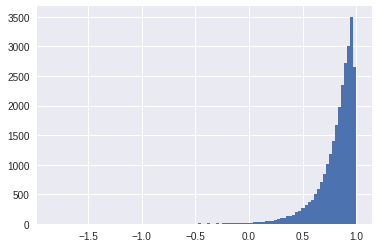

no inter


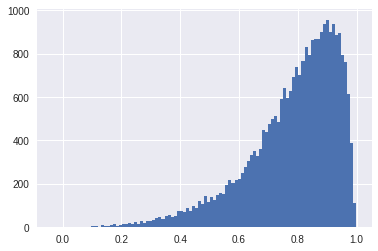

inter
[[  687  5531]
 [ 1037 19865]]
no inter
[[  646  5572]
 [  980 19922]]
orig
[[  362  5856]
 [  480 20422]]
[2.313298   0.01938455 1.05754    0.33370215 0.04552419] [2.31329823 0.01938455 1.05754006 0.33370212 0.04552419]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log


In [29]:
deltaAInter = (1 - motifA_off_preds)/(1 - original_preds) #1+exp(-deltaA)
deltaAnoInter = (1 - AandBoff_preds)/(1 - motifB_off_preds) 
deltaBInter = (1 - motifB_off_preds)/(1 - original_preds) #1+exp(-deltaB)
deltaBnoInter = (1 - AandBoff_preds)/(1 - motifA_off_preds) 

prodABInter = np.multiply(deltaAInter, deltaBInter)
prodInter = np.multiply(1/(1 - AandBoff_preds), prodABInter) 
print(prodInter.shape)
probsInter = 1 - (1/prodInter)

prodABnoInter = np.multiply(deltaAnoInter, deltaBnoInter)
prodnoInter = np.multiply(1/(1 - AandBoff_preds), prodABnoInter) 
probsnoInter = 1 - (1/prodnoInter)

print("inter")
plt.hist(probsInter,bins=100)
plt.show()

print("no inter")
plt.hist(probsnoInter,bins=100)
plt.show()

from sklearn.metrics import confusion_matrix
probsInterBinary = [pred > 0.5 for pred in probsInter]
probsnoInterBinary = [pred > 0.5 for pred in probsnoInter]
probsOrig = [pred > 0.5 for pred in original_preds]

cmInter = confusion_matrix(new_test_labels, probsInterBinary)
cmnoInter = confusion_matrix(new_test_labels, probsnoInterBinary)
cmOrig = confusion_matrix(new_test_labels, probsOrig)
print("inter")
print(cmInter)
print("no inter")
print(cmnoInter)
print("orig")
print(cmOrig)

import keras.backend as K
import tensorflow as tf
lossInter = K.binary_crossentropy(K.variable(new_test_labels), K.variable(probsInter.flatten()))
lossnoInter = K.binary_crossentropy(K.variable(new_test_labels), K.variable(probsnoInter.flatten()))
lossOrig = K.binary_crossentropy(K.variable(new_test_labels), K.variable(original_preds.flatten()))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
lossInter = lossInter.eval(session = sess)
lossnoInter = lossnoInter.eval(session = sess)
lossOrig = lossOrig.eval(session = sess)

def log_loss(y_true, y_preds):
  return -1*(y_true*np.log(y_preds) + (1 - y_true)*np.log(1 - y_preds))

lossInter1 = log_loss(np.asarray(new_test_labels), probsInter.flatten())
print(lossInter[:5], lossInter1[:5])

lossInter


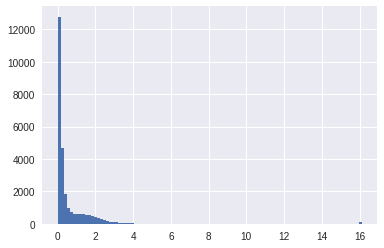

lossOrig


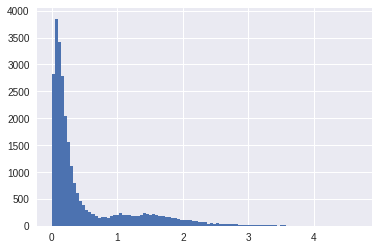

lossnoInter


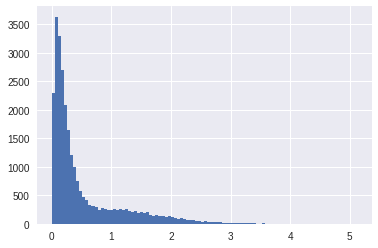

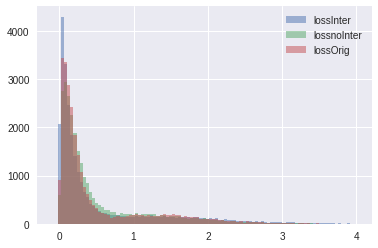

In [31]:
print("lossInter")
plt.hist(lossInter, bins=100)
plt.show()

print("lossOrig")
plt.hist(lossOrig,bins=100)
plt.show()

print("lossnoInter")
plt.hist(lossnoInter,bins=100)
plt.show()

bins = np.linspace(-.1, 4, 100)

pyplot.hist(lossInter, bins, alpha=0.5, label='lossInter')
pyplot.hist(lossnoInter, bins, alpha=0.5, label='lossnoInter')
pyplot.hist(lossOrig, bins, alpha=0.5, label='lossOrig')
pyplot.legend(loc='upper right')
pyplot.show()

In [19]:
null = []
numTrials = 10000
for i in range(numTrials):
  permuted_labels = np.random.permutation(new_test_labels)
  lossInter = log_loss(permuted_labels, probsInter.flatten())
  lossnoInter = log_loss(permuted_labels, probsnoInter.flatten())
  interBetter = [int(lossInter[i] < lossnoInter[i]) for i in range(len(lossInter))]
  frac = float(np.sum(interBetter))/len(lossInter)
  null.append(frac)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log


[0.5866519174041298, 0.5893805309734513, 0.5837020648967551, 0.5874262536873156, 0.5903761061946903, 0.5917772861356932, 0.5875737463126843, 0.5894542772861356, 0.5916297935103245, 0.5858775811209439]


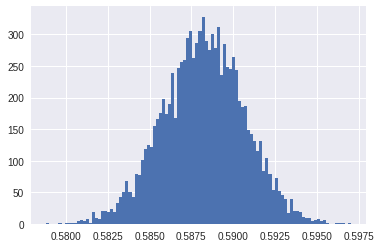

In [20]:
print(null[:10])
from matplotlib import pyplot
plt.hist(null, bins = 100)
plt.show()

In [32]:
interBetter = [int(lossInter[i] < lossnoInter[i]) for i in range(len(lossInter))]
frac = float(np.sum(interBetter))/len(lossInter)
print("actual frac")
print(frac)
print(np.max(null))
pValue = float(np.sum([1 for i in range(len(null)) if null[i] >= frac]))/len(null)
print("pValue")
print(pValue)

actual frac
0.614159292035
0.5970132743362832
pValue
0.0


In [33]:
#paired wilcoxon test
import scipy
from scipy import stats

diff = lossInter - lossnoInter
diffOrigInter = lossInter - lossOrig
diffOrignoInter = lossOrig - lossnoInter

print(probsInter[:7], probsnoInter[:7], original_preds[:7])
indices = []
for i in range(len(lossInter)):
  if diff[i] > 0:
    indices.append(i)
print(len(indices))
print(np.mean(diff))

significance = scipy.stats.wilcoxon(diff)
print(significance)

[[0.9010656 ]
 [0.9808021 ]
 [0.6526909 ]
 [0.7162671 ]
 [0.9554965 ]
 [0.62534106]
 [0.6953707 ]] [[0.5684058 ]
 [0.96097463]
 [0.5124467 ]
 [0.7114196 ]
 [0.9453449 ]
 [0.5750034 ]
 [0.66954285]] [[0.79336137]
 [0.9726284 ]
 [0.5885007 ]
 [0.71385366]
 [0.9506812 ]
 [0.6009652 ]
 [0.68271947]]
10464
0.06877845
WilcoxonResult(statistic=158155838.0, pvalue=1.4331122487696933e-88)
